In [1]:
import onnxruntime as ort
from PIL import Image, ImageDraw
import numpy as np
import sys
import matplotlib.pyplot as plt

In [2]:
sys.path.append('..')

from modelacc import *

In [3]:
model_path = "/home/crinstaniev/Dev/BrainTumorTRTAcc/runs/segment/train/weights/best.onnx"

In [4]:
model = ort.InferenceSession(model_path)

In [5]:
inputs = model.get_inputs()
len(inputs)

1

In [6]:
print("Name: ", inputs[0].name)
print("Shape: ", inputs[0].shape)
print("Type: ", inputs[0].type)

Name:  images
Shape:  [1, 3, 640, 640]
Type:  tensor(float)


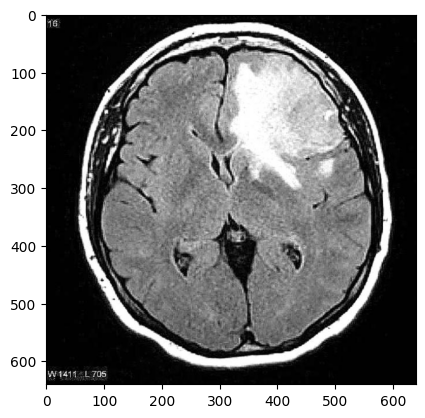

In [7]:
img_path = get_sample_test_image_path()
img = Image.open(img_path)

img_width, img_height = img.size 
img = img.convert("RGB")
img = img.resize((640, 640))

plt.imshow(img)

In [8]:
input = np.array(img)
input = input.transpose(2, 0, 1)
input = input.reshape(1, 3, 640, 640).astype('float32')
input = input/255.0

## Run model

In [9]:
outputs = model.get_outputs()
len(outputs)

2

In [10]:
for output in outputs:
    print("Name: ", output.name)
    print("Shape: ", output.shape)
    print("Type: ", output.type)

Name:  output0
Shape:  [1, 37, 8400]
Type:  tensor(float)
Name:  output1
Shape:  [1, 32, 160, 160]
Type:  tensor(float)


In [11]:
outputs = model.run(None, {"images": input})

## Process Output

In [12]:
# process output 
output0 = outputs[0]
output1 = outputs[1]
print("output0: ", output0.shape, "output1: ", output1.shape)

output0:  (1, 37, 8400) output1:  (1, 32, 160, 160)


In [13]:
output0 = output0[0].transpose()
output1 = output1[0]

print("output0: ", output0.shape, "output1: ", output1.shape)

output0:  (8400, 37) output1:  (32, 160, 160)


In [14]:
boxes = output0[:, 0:5]
masks = output0[:, 5:]
print("boxes:", boxes.shape, "masks:", masks.shape)

boxes: (8400, 5) masks: (8400, 32)


In [15]:
print(masks.shape, output1.shape)

(8400, 32) (32, 160, 160)


In [16]:
output1 = output1.reshape(32, 160 * 160)
print(masks.shape, output1.shape)

(8400, 32) (32, 25600)


In [17]:
masks = masks @ output1
print(masks.shape)

(8400, 25600)


In [18]:
print(boxes.shape, masks.shape)

(8400, 5) (8400, 25600)


In [19]:
boxes = np.hstack((boxes, masks))
print(boxes.shape)

(8400, 25605)


+ 0 - 3: `x_center`, `y_center`, `width`, `height`
+ 4: Object class probability
+ Last 25600: flatten of 160x160 mask

In [20]:
yolo_classes = [
    "tumor"
]


def intersection(box1,box2):
    box1_x1,box1_y1,box1_x2,box1_y2 = box1[:4]
    box2_x1,box2_y1,box2_x2,box2_y2 = box2[:4]
    x1 = max(box1_x1,box2_x1)
    y1 = max(box1_y1,box2_y1)
    x2 = min(box1_x2,box2_x2)
    y2 = min(box1_y2,box2_y2)
    return (x2-x1)*(y2-y1)

def union(box1,box2):
    box1_x1,box1_y1,box1_x2,box1_y2 = box1[:4]
    box2_x1,box2_y1,box2_x2,box2_y2 = box2[:4]
    box1_area = (box1_x2-box1_x1)*(box1_y2-box1_y1)
    box2_area = (box2_x2-box2_x1)*(box2_y2-box2_y1)
    return box1_area + box2_area - intersection(box1,box2)

def iou(box1,box2):
    return intersection(box1,box2)/union(box1,box2)


In [21]:
def get_mask(row, box):
  mask = row.reshape(160, 160)
  return mask

In [22]:
objects = []
for row in boxes:
  prob = row[4].max()
  if prob < 0.5:
    continue
  xc, yc, w, h = row[:4]
  class_id = row[4].argmax()
  x1 = (xc-w/2)/640*img_width
  y1 = (yc-h/2)/640*img_height
  x2 = (xc+w/2)/640*img_width
  y2 = (yc+h/2)/640*img_height
  label = yolo_classes[class_id]
  mask = get_mask(row[5:], (x1, y1, x2, y2))
  objects.append([x1, y1, x2, y2, label, prob, mask])
  
len(objects)

10

In [23]:
# apply nms to filter duplicated box
objects.sort(key=lambda x: x[5], reverse=True)
result = []
while len(objects) > 0:
  result.append(objects[0])
  objects = [object for object in objects if iou(object,objects[0])<0.7]
  
len(result)

1

In [24]:
mask = result[0][6]
print(mask)


[[1.6574829  1.8924679  1.7808044  ... 1.6308545  1.5507902  1.4525687 ]
 [2.376408   1.9515978  1.8274531  ... 1.6018053  1.6373008  1.9690087 ]
 [2.1320646  2.279717   2.4175732  ... 1.8419081  1.8537478  2.2129843 ]
 ...
 [0.9744509  0.93604827 1.1455524  ... 3.3262534  3.3457916  3.362318  ]
 [0.85206765 1.0170273  1.476378   ... 3.6647341  3.574279   3.4841301 ]
 [0.30133462 0.6953506  1.4412162  ... 3.4015255  3.3070877  2.662771  ]]


In [25]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [26]:
mask = sigmoid(mask)
print(mask)

[[0.83989984 0.8690366  0.85579616 ... 0.8362866  0.8250278  0.81039345]
 [0.9150105  0.8756208  0.86145806 ... 0.83227056 0.8371673  0.8775046 ]
 [0.89398086 0.90718323 0.9181576  ... 0.8631742  0.8645665  0.90140945]
 ...
 [0.7260058  0.71830076 0.75869757 ... 0.9653186  0.96596676 0.9665059 ]
 [0.70100075 0.7343932  0.8140249  ... 0.97502863 0.9727289  0.97023284]
 [0.5747688  0.66715616 0.8086429  ... 0.9677521  0.9646712  0.93479383]]


In [27]:
mask = (mask > 0.5).astype('uint8') * 255

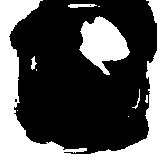

In [28]:
img_mask = Image.fromarray(mask, "L")
img_mask

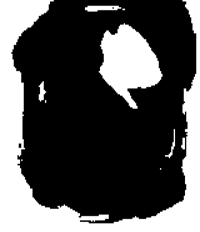

In [29]:
img_mask = img_mask.resize((round(x2 - x1), round(y2 - y1)))
img_mask

In [30]:
mask = np.array(img_mask)

In [31]:
def get_mask(row,box):    
    mask = row.reshape(160,160)
    mask = sigmoid(mask)
    mask = (mask > 0.5).astype('uint8')*255
    x1,y1,x2,y2 = box
    mask_x1 = round(x1/img_width*160)
    mask_y1 = round(y1/img_height*160)
    mask_x2 = round(x2/img_width*160)
    mask_y2 = round(y2/img_height*160)
    mask = mask[mask_y1:mask_y2,mask_x1:mask_x2]
    img_mask = Image.fromarray(mask,"L")
    img_mask = img_mask.resize((round(x2-x1),round(y2-y1)))
    mask = np.array(img_mask)
    return mask


In [32]:
import cv2
def get_polygon(mask):
    contours = cv2.findContours(mask,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    polygon = [[contour[0][0],contour[0][1]] for contour in contours[0][0]]
    return polygon

In [33]:
def get_mask(row,box):    
    mask = row.reshape(160,160)
    mask = sigmoid(mask)
    mask = (mask > 0.5).astype('uint8')*255
    x1,y1,x2,y2 = box
    mask_x1 = round(x1/img_width*160)
    mask_y1 = round(y1/img_height*160)
    mask_x2 = round(x2/img_width*160)
    mask_y2 = round(y2/img_height*160)
    mask = mask[mask_y1:mask_y2,mask_x1:mask_x2]
    img_mask = Image.fromarray(mask,"L")
    img_mask = img_mask.resize((round(x2-x1),round(y2-y1)))
    mask = np.array(img_mask)
    return mask

def get_polygon(mask):
    contours = cv2.findContours(mask,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    polygon = [[contour[0][0],contour[0][1]] for contour in contours[0][0]]
    return polygon

objects = []
for row in boxes:
    prob = row[4].max()
    if prob < 0.5:
        continue
    xc,yc,w,h = row[:4]
    class_id = row[4].argmax()
    x1 = (xc-w/2)/640*img_width
    y1 = (yc-h/2)/640*img_height
    x2 = (xc+w/2)/640*img_width
    y2 = (yc+h/2)/640*img_height
    label = yolo_classes[class_id]
    mask = get_mask(row[5:],(x1,y1,x2,y2))
    polygon = get_polygon(mask)
    objects.append([x1,y1,x2,y2,label,prob,mask,polygon])

objects.sort(key=lambda x: x[5], reverse=True)
result = []
while len(objects)>0:
    result.append(objects[0])
    objects = [object for object in objects if iou(object,objects[0])<0.7]


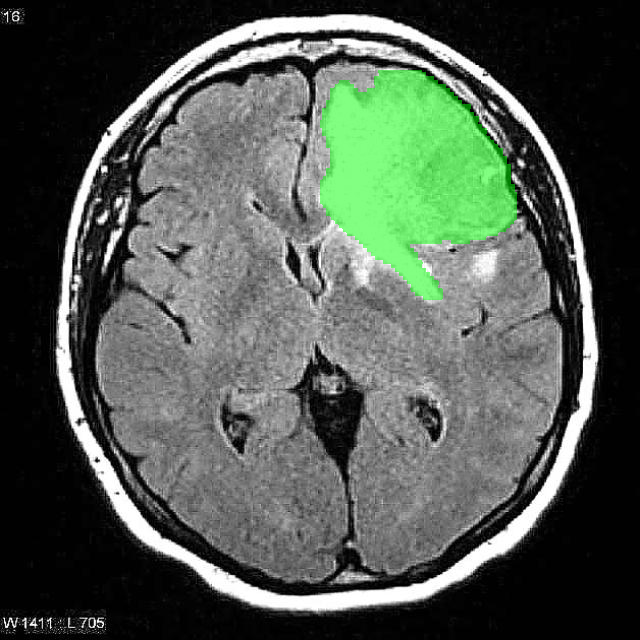

In [34]:
img = Image.open(img_path)
draw = ImageDraw.Draw(img, "RGBA")

for object in result:
    [x1,y1,x2,y2,label,prob,mask,polygon] = object
    polygon = [(int(x1+point[0]),int(y1+point[1])) for point in polygon]
    draw.polygon(polygon,fill=(0,255,0,125))
    
img

In [ ]:
img = Image.open(img_path).convert("RGB")
img_width, img_height = img.size